In [1]:
import cv2 as cv
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from os import listdir, mkdir
from fnmatch import fnmatch

In [2]:
def prepareFits(headers_path, fits_path, headers_pattern, fits_pattern):
    headers_folder = listdir(headers_path)
    fits_folder = listdir(fits_path)

    fits_headers = []
    fits_files = []

    headers_pattern = headers_pattern
    fits_pattern = fits_pattern

    for entry in headers_folder:
        if fnmatch(entry, headers_pattern):
                fits_headers.append('./data/fits_headers/' + entry)

    for entry in fits_folder:
        if fnmatch(entry, fits_pattern):
                fits_files.append('./data/fits_files/' + entry)

    # print(fits_headers[:5])
    # print('Files in headers folder:', len(headers_folder))
    # print('Headers in headers folder:', len(fits_headers))
    # print()
    # print(fits_files[:5])
    # print('Files in fits folder:', len(fits_folder))
    # print('Fits files in fits folder:', len(fits_files))

    fits_headers = np.array(fits_headers)
    fits_files = np.array(fits_files)
    fits_set = set(map(lambda x: x.split('/')[-1].split('.')[0], fits_files))

    return fits_headers, fits_files, fits_set

def getContourEdges(contour):
    min_vert = 71
    min_hor = 10
    align_l = 5
    align_r = 6
    min_height = 20
    min_width = 3
    max_width = 40
    max_height = 140

    x1, x2, mx, y1, y2 = contour[:,0,0].min(), contour[:,0,0].max()+1, contour[:,0,0].mean(), contour[:,0,1].min(), contour[:,0,1].max()+1
    height = y2 - y1
    width = x2 - x1
    if (min_height <= height <= max_height) and (min_width <= width <= max_width) and height > width:
        if height < min_vert:
            y1 = max(0, y2 - min_vert)
        if width < min_hor:
            if mx - x1 < align_l:
                # print("Left alignment:", align_l - (cx - x1))
                x1 = max(0, mx - align_l)
            if x2 - mx < align_r:
                # print("Right alignment:", align_r - (x2 - cx))
                x2 = min(9600, mx + align_r)
        return np.round(np.array([y1, x1, y2, x2], dtype='int'))
    else:
        return None, None, None, None

In [3]:
fits_headers, fits_files, fits_set = prepareFits(
    headers_path='data/fits_headers',
    fits_path='data/fits_files',
    headers_pattern="*.hdr",
    fits_pattern="*.fits")

In [7]:
from tqdm import tqdm
fits_count = 0

import random
random.shuffle(fits_headers)

try:
    mkdir(f'./data/extractedContours/')
except OSError as error:
    pass
try:
    mkdir(f'./data/extractedContours_2/')
except OSError as error:
    pass

for i in tqdm(range(len(fits_headers))):
    plate = fits_headers[i].split('/')[-1].split('.')[0]
    if plate in fits_set:
        fbs_plate = fits.open('./data/fits_files/' + plate + '.fits')

        plate_img = fbs_plate[0].data
        shape_y, shape_x = plate_img.shape
        del fbs_plate
        
        scaled_img = ((plate_img/plate_img.max())*255).astype(np.uint8)
        del plate_img

        if np.mean(scaled_img) < 127.5:
            scaled_img = np.invert(scaled_img)

        gblur = cv.GaussianBlur(scaled_img, (3, 3), 2, 2)
        # del scaled_img #########################################################################

        g_th = cv.adaptiveThreshold(gblur, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
                    cv.THRESH_BINARY_INV,21,2)
        
        del gblur #########################################################################

        contours, hierarchy = cv.findContours(g_th, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)

        for index, contour in enumerate(contours):
            y1, x1, y2, x2 = getContourEdges(contour)

            if all([y1, x1, y2, x2]):
                result = scaled_img[y1:y2, x1:x2]
                result_sized = cv.resize(scaled_img[y1:y2, x1:x2], (20, 140))

                image_path = f'data/extractedContours/{plate}__{index}.png'
                image_2_path = f'data/extractedContours_2/{plate}__{index}.png'

                cv.imwrite(image_path, result)
                cv.imwrite(image_2_path, result_sized)

        fits_count += 1
    if fits_count > 5:
        break

  0%|          | 1/1700 [01:28<41:39:55, 88.28s/it]


KeyboardInterrupt: 

In [226]:
fits_file = fits.open('./data/fits_files/fbs0258_cor.fits')

In [243]:
img = fits_file[0].data
scaled_img = ((img/img.max())*255).astype(np.uint8)
# plt.gray()
# plt.imshow(img)

In [244]:
scaled_img = cv.cvtColor(scaled_img,cv.COLOR_GRAY2RGB)

In [245]:
if len(scaled_img.shape) == 3 and scaled_img.shape[2] == 3:
    scaled_img = cv.cvtColor(scaled_img, cv.COLOR_BGR2GRAY)

In [247]:
scaled_img.shape

(9602, 9601)

In [108]:
if np.mean(scaled_img) < 127.5:
    scaled_img = np.invert(scaled_img)
# plt.gray()
# plt.imshow(scaled_img)

In [109]:
blurred_img = cv.GaussianBlur(scaled_img, (3, 3), 2, 2)

In [110]:
thr_img = cv.adaptiveThreshold(blurred_img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
                    cv.THRESH_BINARY_INV,21,2)

In [111]:
# ret, thresh = cv.threshold(thr_img, 127, 255, 0)
contours, hierarchy = cv.findContours(thr_img, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)

In [112]:
len(contours)

1439060

In [182]:
def getContourEdges(contour):
    min_vert = 71
    min_hor = 10
    align_l = 5
    align_r = 6
    min_height = 20
    min_width = 3
    max_width = 40
    max_height = 140

    x1, x2, mx, y1, y2 = contour[:,0,0].min(), contour[:,0,0].max()+1, contour[:,0,0].mean(), contour[:,0,1].min(), contour[:,0,1].max()+1
    height = y2 - y1
    width = x2 - x1
    if (min_height <= height <= max_height) and (min_width <= width <= max_width) and height > width:
        if height < min_vert:
            y1 = max(0, y2 - min_vert)
        if width < min_hor:
            if mx - x1 < align_l:
                # print("Left alignment:", align_l - (cx - x1))
                x1 = max(0, mx - align_l)
            if x2 - mx < align_r:
                # print("Right alignment:", align_r - (x2 - cx))
                x2 = min(9600, mx + align_r)
        return np.round(np.array([y1, x1, y2, x2], dtype='int'))
    else:
        return None, None, None, None

In [183]:
rectangles = list([])

for contour in contours:
    y1, x1, y2, x2 = getContourEdges(contour)

    if all([y1, x1, y2, x2]):
        rectangles.append((y1, y2, x1, x2))
len(rectangles)

15614

In [ ]:
def getContourEdges(contour):
    min_height = 71
    min_width = 10
    align_l = 5
    align_r = 6
    vertical_diff = 0
    x1, x2, mx, y1, y2 = contour[:,0,0].min(), contour[:,0,0].max()+1, contour[:,0,0].mean(), contour[:,0,1].min(), contour[:,0,1].max()+1
    if y2 - y1 < min_height:
        vertical_diff = min_height - (y2 - y1)
        # print("Top alignment:", )
        y1 = max(0, y2 - min_height)
    if x2 - x1 < min_width:
        if mx - x1 < align_l:
            # print("Left alignment:", align_l - (cx - x1))
            x1 = max(0, mx - align_l)
        if x2 - mx < align_r:
            # print("Right alignment:", align_r - (x2 - cx))
            x2 = min(9600, mx + align_r)
    return y1, x1, y2, x2, vertical_diff


filtered_contours = list([])
rectangles = list([])
min_height = 20
max_width = 40
max_height = 140


for contour in contours:
    y1, x1, y2, x2, vd = getContourEdges(contour)
    height = y2 - y1 - vd
    width = x2 - x1
    if (min_height <= height <= max_height) and (width <= max_width) and height > width:
        filtered_contours.append(contour)
        rectangles.append((y1, y2, x1, x2))
len(rectangles)

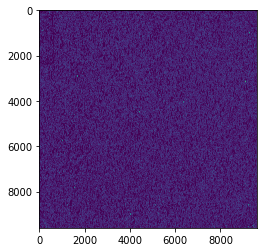

In [114]:
plt.imshow(cv.drawContours(thr_img.copy(), filtered_contours, -1, (0,0,255), 3), cmap='viridis')